# m-skip-n-grams course work

Dataset taken from [Sentiment Analysis in Russian](https://www.kaggle.com/c/sentiment-analysis-in-russian) Kaggle competition.

Unzip data and read it

In [3]:
!unzip /content/drive/MyDrive/data/sent/sentiment-analysis-in-russian.zip

Archive:  /content/drive/MyDrive/data/sent/sentiment-analysis-in-russian.zip
  inflating: sample.csv              
  inflating: test.json               
  inflating: train.json              


In [4]:
import json

In [5]:
with open('/content/train.json') as read_file:
    data = json.load(read_file)

example of data + number text in classes

In [6]:
print('all', len(data))
count_neg = 0
count_pos = 0
for i in data:
    if i['sentiment'] == 'negative':
        count_neg += 1
    elif i['sentiment'] == 'positive':
        count_pos += 1
print('neg', count_neg)
print('pos',count_pos)
print('neg + pos: ', count_pos + count_neg)

all 8263
neg 1434
pos 2795
neg + pos:  4229


In [7]:
data[0]

{'id': 1945,
 'sentiment': 'negative',
 'text': 'Досудебное расследование по факту покупки ЕНПФ пакета облигаций ТОО "Бузгул Аурум" было начато по инициативе Национального банка РК, сообщил директор департамента защиты прав потребителей и финансовых услуг Нацбанка Казахстана Александр Терентьев.\n"Основанием для досудебного расследования стало обращение Национального банка, письмо от 25 ноября 2016 года. Было обращение Национального банка в правоохранительные органы. Нам эта сделка показалась сомнительной, недостаточно корректной, поэтому Нацбанк 25 ноября 2016 года обратился в правоохранительные органы. Это то, что я могу озвучить на сегодня. Идёт следствие, проводится проверка", – сказал Терентьев.\n28 декабря в Нацбанке заявили, что не знают, что стало основанием для проверки ЕНПФ.\n23 декабря факт проведения проверки в АО "Единый накопительный пенсионный фонд" подтвердился. Пресс-служба Национального банка сообщила, что проверку проводят по операциям, совершённым АО "ЕНПФ" в отноше

Import nltk, download stopwords and puctiation.

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


install pymorphy2 for lemmatize

In [9]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 8.2MB 6.7MB/s 


Load positive/negative token from [AIgent](https://github.com/aigents/aigents-java)

In [10]:
pos_path = '/content/drive/MyDrive/data/sent/lexicon_positive_russian.txt'
neg_path = '/content/drive/MyDrive/data/sent/lexicon_negative_russian.txt'

In [11]:
pos_token = []
lenght_token = set()
with open(pos_path) as f:
    for line in f.readlines():
        pos_token.append(line.strip().split(" "))
        lenght_token.add(len(line.strip().split(" ")))
print('number positive tokens:', len(pos_token))
print('lenghts positive tokens:', lenght_token)

number positive tokens: 3341
lenghts positive tokens: {1, 2, 3, 4, 5}


In [12]:
neg_token = []
lenght_token = set()
with open(neg_path) as f:
    for line in f.readlines():
        neg_token.append(line.strip().split(" "))
        lenght_token.add(len(line.strip().split(" ")))
print('number negative tokens:', len(neg_token))
print('lenghts negative tokens:', lenght_token)

number negative tokens: 9745
lenghts negative tokens: {1, 2, 3, 4, 5}


import libraries 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re
from nltk.util import skipgrams
from functools import partial
from random import choice
from sklearn.metrics import classification_report
from pymorphy2 import MorphAnalyzer

Create custome dictionary of ngramm for encoding based on AIgent positive/negative tokens.

In [14]:
index = 0
vocabulary = {}
for token in pos_token:
    vocabulary[' '.join(token)] = index
    index += 1 
for token in neg_token:
    vocabulary[' '.join(token)] = index
    index += 1 

define m_skip_n_gramm_tokenizer which create from 1-gram to n-gram lemmatized token wirh skip m

In [15]:
def m_skip_n_gramm_tokenizer(doc, m, n, stopwords_ru):
    morph = MorphAnalyzer()
    patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    ngrams = tokens.copy()
    if n > 1:
        for i in range(2, n+1):
            ngrams += list(skipgrams(tokens, i, m))
    return ngrams

In [16]:
 custome_tokenizer = partial(m_skip_n_gramm_tokenizer, n=3, m=2, stopwords_ru = stopwords.words("russian"))

Takes only positive/ negative sentiments and according texts 

In [17]:
texts = []
sentiments = []
for i in data:
    if i['sentiment'] != 'neutral':
        texts.append(i['text'])
        sentiments.append(i['sentiment'])

simple ngram model 

In [ ]:
cv = CountVectorizer(texts, tokenizer=custome_tokenizer, vocabulary=vocabulary)
count_vector = cv.transform(texts)

In [ ]:
count_vector = count_vector.toarray()

simple discrimator

In [ ]:
def simple_uniform_prediction(count_vector, pos_num=3341):
    pred = []
    for i in range(count_vector.shape[0]):
        num_pos_token = np.sum(count_vector[i, 0:3341])
        num_neg_token = np.sum(count_vector[i, 3341:-1])
        if num_pos_token > num_neg_token :
            pred.append('positive')
        elif num_pos_token < num_neg_token:
            pred.append('negative')
        else:
            pred.append(choice(['negative', 'positive']))
    return pred
simple_uniform_prediction(count_vector

result of simple discriminator

In [ ]:
num_true_pred = 0
num_all =0
for i in range(len(sentiments)):
    sent = sentiments[i]
    if sent == 'positive':
        if pred[i] == 'positive':
            num_true_pred += 1
        num_all += 1
    elif sent == 'negative':
        if pred[i] == 'negative':
            num_true_pred += 1
        num_all += 1
    else:
        pass
        #if pred[i] == 'neitral':
        #    num_true_pred += 1
        #num_all += 1
num_true_pred / num_all

0.7625916292267676

In [ ]:
print(classification_report(sentiments, pred))

              precision    recall  f1-score   support

    negative       0.65      0.65      0.65      1434
    positive       0.82      0.82      0.82      2795

    accuracy                           0.76      4229
   macro avg       0.74      0.74      0.74      4229
weighted avg       0.76      0.76      0.76      4229



Logistic regression model

In [ ]:
X = []
y = []
for i in range(len(sentiments)):
    sent = sentiments[i]
    if sent == 'positive':
        y.append(1.0)
        X.append(count_vector[i])
    elif sent == 'negative':
        y.append(0.0)
        X.append(count_vector[i])
    else:
        pass
X = np.array(X)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.80, random_state=7)

In [ ]:
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)
print(classification_report(y_train, logit.predict(X_train)))
print(classification_report(y_val, logit.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      1179
         1.0       0.95      0.99      0.97      2204

    accuracy                           0.96      3383
   macro avg       0.97      0.95      0.96      3383
weighted avg       0.97      0.96      0.96      3383

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       255
         1.0       0.91      0.95      0.93       591

    accuracy                           0.90       846
   macro avg       0.89      0.87      0.88       846
weighted avg       0.90      0.90      0.90       846



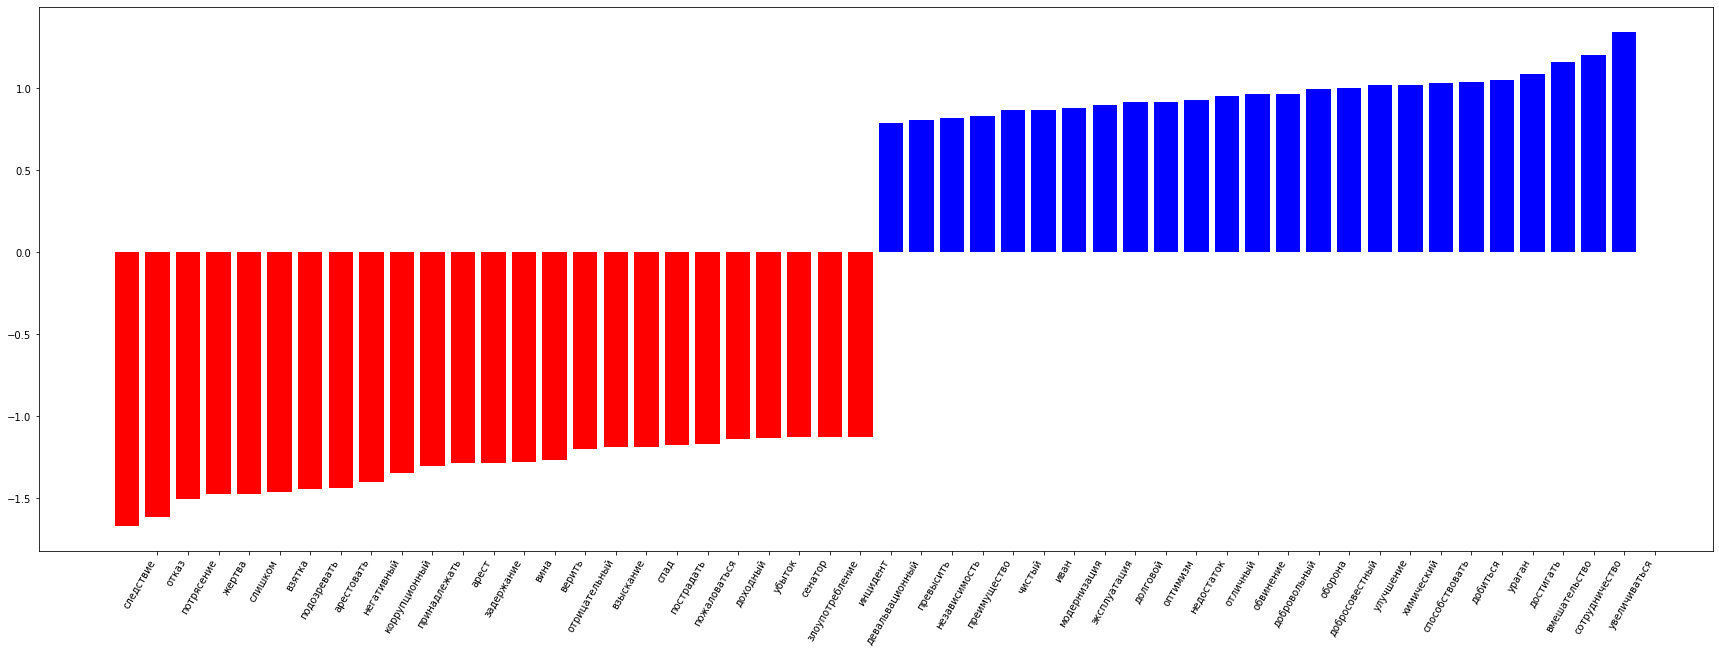

In [ ]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
# get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
# plot them
    plt.figure(figsize=(30, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

visualize_coefficients(logit, list(vocabulary.keys()))

result with 

In [158]:
history = []
for m in [1,2,3]:
    for n in [1,2,3,4]:
        custome_tokenizer = partial(m_skip_n_gramm_tokenizer, n=n, m=m, stopwords_ru = stopwords.words("russian"))
        cv = CountVectorizer(texts, tokenizer=custome_tokenizer, vocabulary=vocabulary)
        count_vector = cv.transform(texts)
        count_vector = count_vector.toarray()
        X = []
        y = []
        for i in range(len(sentiments)):
            sent = sentiments[i]
            if sent == 'positive':
                y.append(1.0)
                X.append(count_vector[i])
            elif sent == 'negative':
                y.append(0.0)
                X.append(count_vector[i])
            else:
                pass
        X = np.array(X)
        y = np.array(y)
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.80,)
        logit = LogisticRegression(n_jobs=-1, random_state=7)
        logit.fit(X_train, y_train)
        score = logit.score(X_val, y_val)
        print('n: ', n, 'm: ', m, 'score: ', score)
        history.append({'n':n,'m':m, 'score':score})

n:  1 m:  1 score:  0.8829787234042553
n:  2 m:  1 score:  0.8865248226950354
n:  3 m:  1 score:  0.8770685579196218
n:  4 m:  1 score:  0.8735224586288416
n:  1 m:  2 score:  0.875886524822695
n:  2 m:  2 score:  0.875886524822695
n:  3 m:  2 score:  0.875886524822695
n:  4 m:  2 score:  0.8770685579196218
n:  1 m:  3 score:  0.8947990543735225
n:  2 m:  3 score:  0.892434988179669
n:  3 m:  3 score:  0.8640661938534279
n:  4 m:  3 score:  0.8900709219858156


In [202]:
def m_skip_n_gramm_tokenizer(doc, m, n, stopwords_ru):
    morph = MorphAnalyzer()
    patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    ngrams = tokens.copy()
    if n > 1:
        for i in range(2, n+1):
            skipgrams_tokens = [' '.join(i) for i in list(skipgrams(tokens, i, m))]
            ngrams += skipgrams_tokens
    return ngrams

In [207]:
history = []
for m in [1,2,3]:
    for n in [1,2,3,4]:
        custome_tokenizer1 = partial(m_skip_n_gramm_tokenizer, n=n, m=m, stopwords_ru = stopwords.words("russian"))
        cv = CountVectorizer(texts, tokenizer=custome_tokenizer1, vocabulary=vocabulary)
        count_vector = cv.transform(texts)
        count_vector = count_vector.toarray()
        X = []
        y = []
        for i in range(len(sentiments)):
            sent = sentiments[i]
            if sent == 'positive':
                y.append(1.0)
                X.append(count_vector[i])
            elif sent == 'negative':
                y.append(0.0)
                X.append(count_vector[i])
            else:
                pass
        X = np.array(X)
        y = np.array(y)
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.80)
        logit = LogisticRegression(n_jobs=-1, random_state=7)
        logit.fit(X_train, y_train)
        score = logit.score(X_val, y_val)
        print('n: ', n, 'm: ', m, 'score: ', score)
        history.append({'n':n,'m':m, 'score':score})

n:  1 m:  1 score:  0.8794326241134752
n:  2 m:  1 score:  0.8817966903073287
n:  3 m:  1 score:  0.8687943262411347
n:  4 m:  1 score:  0.892434988179669
n:  1 m:  2 score:  0.8770685579196218
n:  2 m:  2 score:  0.8782505910165485
n:  3 m:  2 score:  0.8853427895981087
n:  4 m:  2 score:  0.8900709219858156
n:  1 m:  3 score:  0.8829787234042553
n:  2 m:  3 score:  0.8711583924349882
n:  3 m:  3 score:  0.8806146572104019
n:  4 m:  3 score:  0.8971631205673759


result with stop word

In [213]:
        m, n = 3, 4
        custome_tokenizer1 = partial(m_skip_n_gramm_tokenizer, n=n, m=m, stopwords_ru =[])
        cv = CountVectorizer(texts, tokenizer=custome_tokenizer1, vocabulary=vocabulary)
        count_vector = cv.transform(texts)
        count_vector = count_vector.toarray()
        X = []
        y = []
        for i in range(len(sentiments)):
            sent = sentiments[i]
            if sent == 'positive':
                y.append(1.0)
                X.append(count_vector[i])
            elif sent == 'negative':
                y.append(0.0)
                X.append(count_vector[i])
            else:
                pass
        X = np.array(X)
        y = np.array(y)
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.80)
        logit = LogisticRegression(n_jobs=-1, random_state=7)
        logit.fit(X_train, y_train)
        score = logit.score(X_val, y_val)
        print('n: ', n, 'm: ', m, 'score: ', score)
        history.append({'n':n,'m':m, 'score':score})

n:  4 m:  3 score:  0.8888888888888888


Lemmantize dictianry and eval with this vocabulary

In [50]:
index = 0
vocabulary = {}
morph = MorphAnalyzer()
for token in pos_token:
    tokens = []
    for i in token:
        tokens.append(morph.normal_forms(i)[0])
    if ' '.join(tokens) not in list(vocabulary.keys()):
        vocabulary[' '.join(tokens)] = index
        index += 1
for token in neg_token:
    tokens = []
    for i in token:
        tokens.append(morph.normal_forms(i)[0])
    if ' '.join(tokens) not in list(vocabulary.keys()):
        vocabulary[' '.join(tokens)] = index
        index += 1

In [ ]:
        m, n = 3, 4
        custome_tokenizer1 = partial(m_skip_n_gramm_tokenizer, n=n, m=m, stopwords_ru =[])
        cv = CountVectorizer(texts, tokenizer=custome_tokenizer1, vocabulary=vocabulary)
        count_vector = cv.transform(texts)
        count_vector = count_vector.toarray()
        X = []
        y = []
        for i in range(len(sentiments)):
            sent = sentiments[i]
            if sent == 'positive':
                y.append(1.0)
                X.append(count_vector[i])
            elif sent == 'negative':
                y.append(0.0)
                X.append(count_vector[i])
            else:
                pass
        X = np.array(X)
        y = np.array(y)
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.80)
        logit = LogisticRegression(n_jobs=-1, random_state=7)
        logit.fit(X_train, y_train)
        score = logit.score(X_val, y_val)
        print('n: ', n, 'm: ', m, 'score: ', score)

In [52]:
print('n: ', n, 'm: ', m, 'score: ', score)

n:  4 m:  3 score:  0.8841607565011821
